In [1]:
import os
from os.path import join, exists
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score

from mnist_A_data_loader import get_mnist_A_loader
from models import *
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
pos_x_list = [0, 36]
pos_y_list = [0]
angle_list = [0]
scale_list = [28] 
unique_label = []
for m in [1, 2]:
    for k2, pos_y in enumerate(pos_y_list):
        for k1, pos_x in enumerate(pos_x_list):
            for j, angle in enumerate(angle_list):
                theta = np.pi * angle/180
                sin = np.sin(theta).round(3)
                cos = np.cos(theta).round(3)
                for i, scale in enumerate(scale_list):
                    unique_label.append([scale, sin, cos, pos_x, pos_y, m])
unique_label = np.array(unique_label)

In [6]:
train_loader = get_mnist_A_loader("../data/MNIST_A/train_X/",
                                  "../data/MNIST_A/train_y.npy", unique_label, onehot=False)
test_loader = get_mnist_A_loader("../data/MNIST_A/test_X/",
                                 "../data/MNIST_A/test_y.npy", unique_label, onehot=False, mode="test")
valid_loader = get_mnist_A_loader("../data/MNIST_A/valid_X/",
                                  "../data/MNIST_A/valid_y.npy", unique_label, onehot=False, mode="valid")

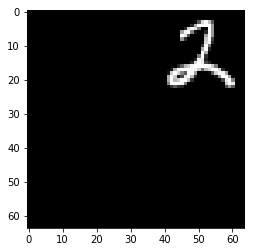

In [7]:
x, y = iter(test_loader).next()
plt.imshow(x[4][0].numpy(), plt.cm.gray)
plt.show()

In [8]:
classifier = MNIST_A_Classifier().to(device)
criterion_bce = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=5e-4)

# 訓練

625it [00:24, 25.42it/s]


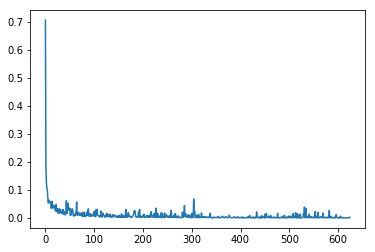

625it [00:23, 26.13it/s]


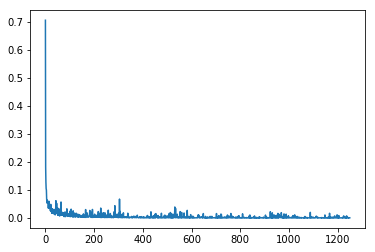

625it [00:23, 26.29it/s]


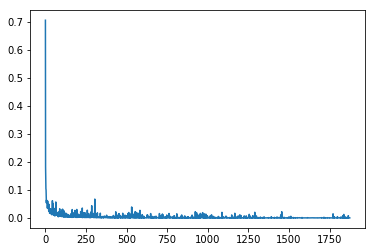

In [9]:
classifier.train()

loss_plot = []
for epoch in range(3):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = label2onehot(y)
        y = y.to(device)
        
        optimizer.zero_grad()

        pred_y = classifier(x)
        loss = criterion_bce(pred_y, y)
        
        loss.backward()
        optimizer.step()
        
        loss_plot.append(loss.detach())
        
    plt.plot(loss_plot)
    plt.show()

log_dir = "logs"
if not exists(log_dir):
    os.makedirs(log_dir)
torch.save(classifier.state_dict(), join(log_dir, 'MNIST_A_classifier.pkl'))

テスト

In [14]:
log_dir = "./logs"
classifier = MNIST_A_Classifier().to(device)
classifier.load_state_dict(torch.load(join(log_dir, 'MNIST_A_classifier.pkl')))
classifier.eval()

preds = []
ys = []
for batch_idx, (data, label) in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        data = data.to(device)
        pred = classifier(data) > 0.5
        ys.extend(label2onehot(label.numpy()))
        preds.extend(pred.detach().cpu().numpy())

preds = np.array(preds)
ys = np.array(ys)

for i, title in enumerate(["position", "label"]):
    print(title)
    print(confusion_matrix(ys[:, i], preds[:, i]))
    print(classification_report(ys[:, i], preds[:, i]))
    print(precision_score(ys[:, i], preds[:, i], average='macro'))
    print("")

63it [00:02, 28.29it/s]


position
[[4000    0]
 [   0 4000]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4000
         1.0       1.00      1.00      1.00      4000

   micro avg       1.00      1.00      1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

1.0

label
[[3988   12]
 [  15 3985]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4000
         1.0       1.00      1.00      1.00      4000

   micro avg       1.00      1.00      1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000

0.996625279352

